In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import timedelta

In [2]:
df = pd.read_csv('intel_stock_price.csv')

# Chuyển đổi cột Date sang định dạng datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sắp xếp dữ liệu theo thứ tự tăng dần của ngày
df = df.sort_values('Date')

# Loại bỏ ký tự 'M' và '%' trong các cột và chuyển sang kiểu số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Hiển thị thông tin ban đầu
print("Thông tin dữ liệu:")
print(df.head())

Thông tin dữ liệu:
           Date  Price   Open   High    Low   Vol.  Change %
1076 2020-12-31  49.82  48.75  50.19  48.72  28.58      2.19
1075 2021-01-04  49.67  49.89  51.39  49.40  46.10     -0.30
1074 2021-01-05  50.61  49.45  50.83  49.33  24.87      1.89
1073 2021-01-06  51.10  50.44  52.15  50.20  36.81      0.97
1072 2021-01-07  52.19  51.49  52.69  51.30  32.09      2.13


In [3]:
# Chọn cột 'Price' làm đặc trưng để dự đoán
data = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tiền xử lý dữ liệu và chia tập dữ liệu
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Độ dài chuỗi (số ngày sử dụng để dự đoán)
sequence_length = 10

# Tạo chuỗi dữ liệu
X, y = create_sequences(scaled_data, sequence_length)

# Tính số lượng mẫu cho mỗi tập dữ liệu
train_size = int(len(X) * 0.7)
test_size = int(len(X) * 0.2)
val_size = len(X) - train_size - test_size

# Chia tập dữ liệu
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]
X_val, y_val = X[train_size + test_size:], y[train_size + test_size:]

In [4]:
# Xây dựng mô hình RNN từ đầu 
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Khởi tạo trọng số
        # Trọng số cho lớp đầu vào -> lớp ẩn
        self.W_xh = np.random.randn(input_size, hidden_size) * 0.01
        # Trọng số cho lớp ẩn -> lớp ẩn (trạng thái ẩn)
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        # Bias cho lớp ẩn
        self.b_h = np.zeros((1, hidden_size))
        
        # Trọng số cho lớp ẩn -> lớp đầu ra
        self.W_hy = np.random.randn(hidden_size, output_size) * 0.01
        # Bias cho lớp đầu ra
        self.b_y = np.zeros((1, output_size))
        
    def forward(self, x):
        # x có kích thước (batch_size, sequence_length, input_size)
        batch_size, seq_length, input_size = x.shape
        
        # Khởi tạo trạng thái ẩn ban đầu
        h = np.zeros((batch_size, self.hidden_size))
        
        # Danh sách lưu trạng thái ẩn qua từng bước thời gian
        self.h_states = []
        
        # Truyền qua từng bước thời gian
        for t in range(seq_length):
            # Lấy đầu vào tại bước thời gian t
            x_t = x[:, t, :]
            
            # Tính trạng thái ẩn mới
            h = np.tanh(np.dot(x_t, self.W_xh) + np.dot(h, self.W_hh) + self.b_h)
            
            # Lưu trạng thái ẩn
            self.h_states.append(h)
        
        # Tính đầu ra từ trạng thái ẩn cuối cùng
        y_pred = np.dot(h, self.W_hy) + self.b_y
        
        return y_pred
    
    def train(self, X, y, X_val, y_val, learning_rate=0.01, epochs=100, batch_size=32):
        # Lưu lại lịch sử loss
        train_losses = []
        val_losses = []
        
        # Số lượng batch
        n_batches = int(np.ceil(len(X) / batch_size))
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            # Tạo shuffle index
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(n_batches):
                # Lấy batch
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, len(X))
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                
                # Tính loss (MSE)
                loss = np.mean((y_pred - y_batch) ** 2)
                epoch_loss += loss
                
                # Tính gradient
                # Gradient cho đầu ra
                grad_y = 2 * (y_pred - y_batch) / len(y_batch)
                
                # Gradient cho trọng số từ hidden -> output
                grad_W_hy = np.dot(self.h_states[-1].T, grad_y)
                grad_b_y = np.sum(grad_y, axis=0, keepdims=True)
                
                # Gradient cho trạng thái ẩn cuối cùng
                grad_h = np.dot(grad_y, self.W_hy.T)
                
                # Backpropagation qua thời gian (BPTT)
                grad_W_xh = np.zeros_like(self.W_xh)
                grad_W_hh = np.zeros_like(self.W_hh)
                grad_b_h = np.zeros_like(self.b_h)
                
                # Chỉ thực hiện BPTT đơn giản cho bước cuối cùng
                h_prev = self.h_states[-2] if len(self.h_states) > 1 else np.zeros((len(X_batch), self.hidden_size))
                x_t = X_batch[:, -1, :]
                
                # Gradient cho đầu vào -> trạng thái ẩn
                grad_W_xh += np.dot(x_t.T, grad_h * (1 - self.h_states[-1] ** 2))
                
                # Gradient cho trạng thái ẩn -> trạng thái ẩn
                grad_W_hh += np.dot(h_prev.T, grad_h * (1 - self.h_states[-1] ** 2))
                
                # Gradient cho bias của trạng thái ẩn
                grad_b_h += np.sum(grad_h * (1 - self.h_states[-1] ** 2), axis=0, keepdims=True)
                
                # Cập nhật trọng số
                self.W_hy -= learning_rate * grad_W_hy
                self.b_y -= learning_rate * grad_b_y
                self.W_xh -= learning_rate * grad_W_xh
                self.W_hh -= learning_rate * grad_W_hh
                self.b_h -= learning_rate * grad_b_h
            
            # Tính loss trung bình trên tập huấn luyện
            epoch_loss /= n_batches
            train_losses.append(epoch_loss)
            
            # Đánh giá trên tập validation
            val_preds = self.predict(X_val)
            val_loss = np.mean((val_preds - y_val) ** 2)
            val_losses.append(val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        return train_losses, val_losses
    
    def predict(self, X):
        # Dự đoán trên toàn bộ tập dữ liệu
        predictions = np.zeros((len(X), 1))
        
        for i in range(len(X)):
            # Định dạng lại đầu vào cho một mẫu
            x = X[i:i+1]
            
            # Forward pass
            pred = self.forward(x)
            predictions[i] = pred
            
        return predictions

In [5]:
# Reshape dữ liệu cho mô hình RNN
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_rnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Khởi tạo và huấn luyện mô hình RNN
input_size = 1  # Một đặc trưng (giá)
hidden_size = 32  # Số nút trong lớp ẩn
output_size = 1  # Dự đoán một giá trị (giá cho ngày tiếp theo)

rnn_model = SimpleRNN(input_size, hidden_size, output_size)

# Huấn luyện mô hình
train_losses, val_losses = rnn_model.train(
    X_train_rnn, y_train, 
    X_val_rnn, y_val,
    learning_rate=0.01, 
    epochs=100, 
    batch_size=16
)

y_pred_RNN = rnn_model.predict(X_test_rnn)

Epoch 10/100, Train Loss: 0.0520, Val Loss: 0.1687
Epoch 20/100, Train Loss: 0.0508, Val Loss: 0.1657
Epoch 30/100, Train Loss: 0.0473, Val Loss: 0.1553
Epoch 40/100, Train Loss: 0.0389, Val Loss: 0.1319
Epoch 50/100, Train Loss: 0.0246, Val Loss: 0.0835
Epoch 60/100, Train Loss: 0.0088, Val Loss: 0.0279
Epoch 70/100, Train Loss: 0.0016, Val Loss: 0.0039
Epoch 80/100, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 90/100, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 100/100, Train Loss: 0.0004, Val Loss: 0.0004


In [6]:
# Chuyển đổi dự đoán về thang đo ban đầu
y_test_inv = scaler.inverse_transform(y_test)
y_pred_RNN_inv = scaler.inverse_transform(y_pred_RNN)

# Dự đoán trên tập validation
y_pred_val = rnn_model.predict(X_val_rnn)
y_val_inv = scaler.inverse_transform(y_val)
y_pred_val_inv = scaler.inverse_transform(y_pred_val)

In [7]:
# Tập test
test_rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_RNN_inv))
test_mse = mean_squared_error(y_test_inv, y_pred_RNN_inv)
test_mae = mean_absolute_error(y_test_inv, y_pred_RNN_inv)

print("\nĐánh giá mô hình RNN trên tập test:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")


Đánh giá mô hình RNN trên tập test:
RMSE: 1.1479
MSE: 1.3176
MAE: 0.7329


In [8]:
# Tập validation
val_rmse = math.sqrt(mean_squared_error(y_val_inv, y_pred_val_inv))
val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)
val_mae = mean_absolute_error(y_val_inv, y_pred_val_inv)

print("\nĐánh giá mô hình RNN trên tập validation:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")


Đánh giá mô hình RNN trên tập validation:
RMSE: 1.0166
MSE: 1.0334
MAE: 0.7051


In [9]:
# Hàm dự đoán giá trong tương lai
def predict_future(model, last_sequence, n_days, scaler):

    curr_sequence = last_sequence.copy()
    predictions = []
    
    for _ in range(n_days):
        # Chuẩn bị đầu vào cho mô hình (1 mẫu, chuỗi dữ liệu, 1 đặc trưng)
        x = curr_sequence.reshape(1, curr_sequence.shape[0], 1)
        
        # Dự đoán giá tiếp theo
        next_pred = model.forward(x)
        
        # Thêm giá trị dự đoán vào danh sách kết quả
        predictions.append(next_pred[0, 0])
        
        # Cập nhật chuỗi cho lần dự đoán tiếp theo
        curr_sequence = np.roll(curr_sequence, -1)
        curr_sequence[-1] = next_pred[0, 0]
    
    # Chuyển đổi dự đoán về thang đo ban đầu
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Lấy chuỗi dữ liệu cuối cùng để dự đoán
last_sequence = scaled_data[-sequence_length:]

# Dự đoán giá cho 30 ngày tiếp theo
predictions_30_days = predict_future(rnn_model, last_sequence, 30, scaler)

# Tạo các ngày cho 30 ngày đầu tiên
last_date = df['Date'].iloc[-1]
future_dates_30 = [last_date + timedelta(days=i+1) for i in range(30)]

# Cập nhật chuỗi sau 30 ngày dự đoán đầu tiên
updated_sequence = np.array(predictions_30_days[-sequence_length:]).reshape(-1, 1)
# Chuẩn hóa lại chuỗi để dùng làm đầu vào cho dự đoán tiếp theo
updated_sequence = scaler.transform(updated_sequence)

# Dự đoán tiếp 30 ngày nữa (từ ngày 31 đến ngày 60)
predictions_next_30_days = predict_future(rnn_model, updated_sequence, 30, scaler)

# Tạo các ngày cho 30 ngày tiếp theo (từ ngày 31 đến ngày 60)
last_date_30 = future_dates_30[-1]
future_dates_next_30 = [last_date_30 + timedelta(days=i+1) for i in range(30)]

# Kết hợp để có dữ liệu dự đoán cho 60 ngày
predictions_60_days = np.concatenate([predictions_30_days, predictions_next_30_days])
future_dates_60 = future_dates_30 + future_dates_next_30

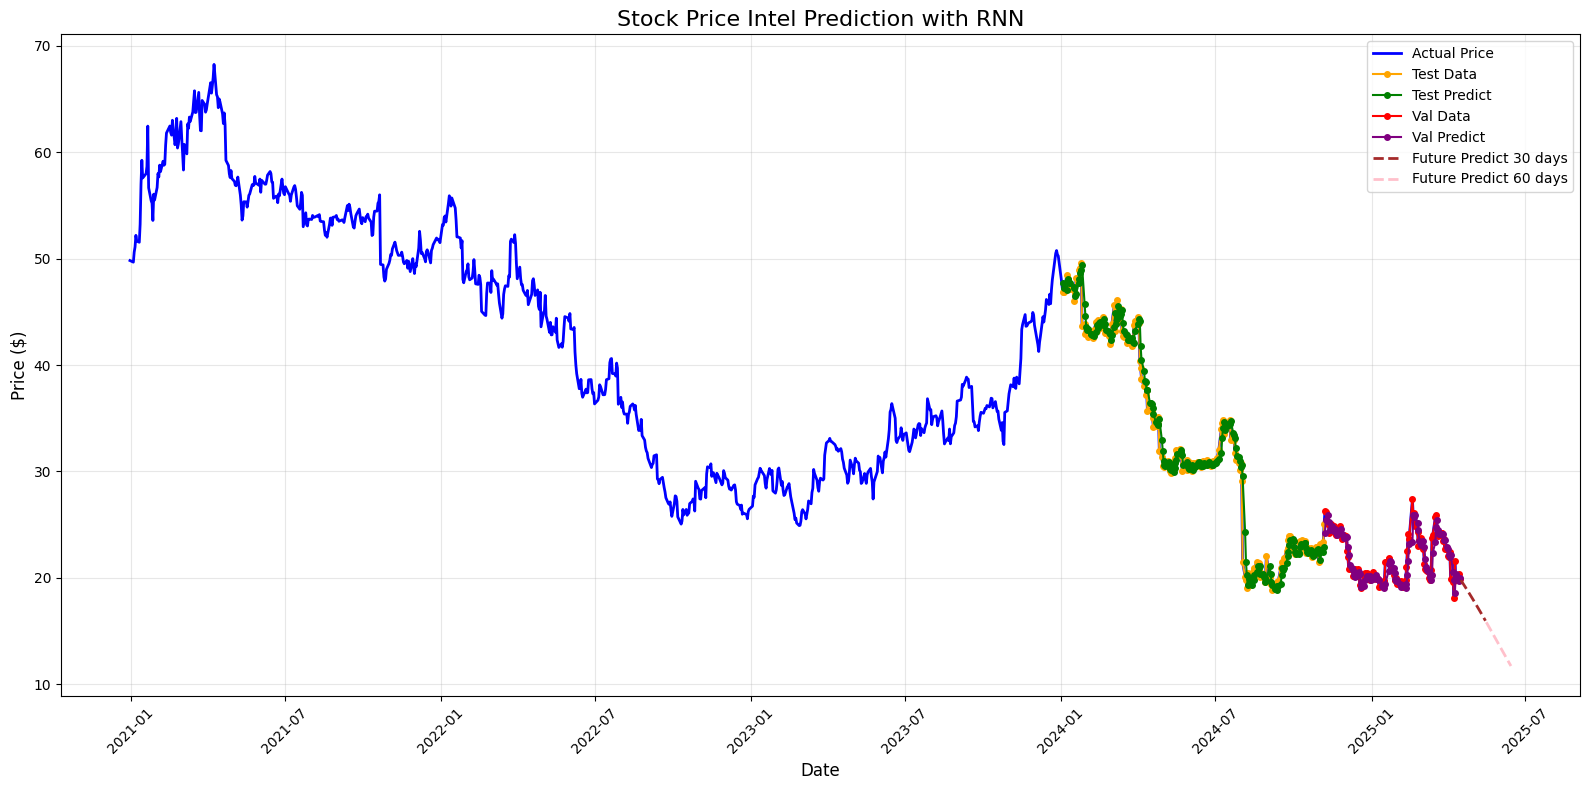

In [11]:
# Chuẩn bị dữ liệu cho việc vẽ biểu đồ
train_dates = df['Date'].iloc[sequence_length:sequence_length+len(y_train)]
test_dates = df['Date'].iloc[sequence_length+len(y_train):sequence_length+len(y_train)+len(y_test)]
val_dates = df['Date'].iloc[sequence_length+len(y_train)+len(y_test):]

# Lấy giá thực tế
train_data = df['Price'].iloc[sequence_length:sequence_length+len(y_train)].values
test_data = df['Price'].iloc[sequence_length+len(y_train):sequence_length+len(y_train)+len(y_test)].values
val_data = df['Price'].iloc[sequence_length+len(y_train)+len(y_test):].values

# Thực hiện dự đoán trên tập huấn luyện
y_pred_train = rnn_model.predict(X_train_rnn)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

# Vẽ biểu đồ với tất cả các đường theo yêu cầu
plt.figure(figsize=(16, 8))

# Giá thực tế - Màu xanh dương
plt.plot(df['Date'], df['Price'], label='Actual Price', color='blue', linewidth=2)

# Dữ liệu test - Màu cam
plt.plot(test_dates, test_data, 'o-', label='Test Data', color='orange', linewidth=1.5, markersize=4)

# Dự đoán test - Màu xanh lục
plt.plot(test_dates, y_pred_RNN_inv, 'o-', label='Test Predict', color='green', linewidth=1.5, markersize=4)

# Dữ liệu validation - Màu đỏ
plt.plot(val_dates, val_data, 'o-', label='Val Data', color='red', linewidth=1.5, markersize=4)

# Dự đoán validation - Màu tím
plt.plot(val_dates, y_pred_val_inv, 'o-', label='Val Predict', color='purple', linewidth=1.5, markersize=4)

# Dự đoán cho 30 ngày tiếp theo - Màu nâu đậm
plt.plot(future_dates_30, predictions_30_days, '--', label='Future Predict 30 days', color='brown', linewidth=2)

# Dự đoán cho 30 ngày tiếp theo (ngày 31-60) - Màu hồng
plt.plot(future_dates_next_30, predictions_next_30_days, '--', label='Future Predict 60 days', color='pink', linewidth=2)

plt.title('Stock Price Intel Prediction with RNN', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

# Đặt định dạng cho trục x để hiển thị ngày rõ ràng hơn
plt.xticks(rotation=45)
plt.tight_layout()

# Lưu biểu đồ
plt.show()